In [1]:
from scipy import stats
import numpy as np

# Approximate Bayesian Computation

Generative models are models which we can generate new data with. Often we do not know an explicit formulation for a generative model (They are black-boxes), especially when they occur in the real-world. Mathematically, generative models are those which capture the distribution of $\mathbb{P}(X,Y)$ where $X,Y$ are observed data and its labels, rather than $\mathbb{P}(Y|X)$ which discriminative models capture.

Approximate Bayesian Computation (ABC) is a family of computational methods, based on Bayesian Statistics, which use simulation to estimate the posterior for parameter values for theorised models, without having to evaluate the likelihood function.

These simulated values can then be used to either produce an estimate of the whole posterior (using methods such as kernel density estimation) or to estimate quantities from the posterior (commonly, its mean). These estimations can then be used to fit a theorised model's parameters.

In this notebook I introduce and demonstrate a few ABC algorithms which I have implemented in `ABC.py`.

**Table of Contents**
 * [Motivation](#Motivation-for-ABC)
 * [Modelling](#Modelling)
     * [Models.LinearModels](#Models.LinearModel)
     * [Models.ExponentialModels](#Models.ExponentialModels)
 * [Kernels](#Kernels-$K_\epsilon$)
 * [Summary Statistics](#Summary-Statistics-$s$)
     * [Sufficiency](#Sufficiency)
 * [ABC Algorithms](#ABC-Algorithms)
     * [Components of ABC](#Components-of-ABC)
     * [ABC-Rejection Sampling](#ABC-Rejection-Sampling)
         * [Implementation](#rejection_implementation)
             * [Linear Model](#rejection_linear_model)
             * [Exponential Model](#rejection_exponential_model)
     * [ABC-MCMC](#ABC-MCMC)
         * [Implementation](#mcmc_implementation)
             * [Linear Model](#mcmc_linear_model)
             * [Exponential Model](#mcmc_exponential_model)
     * [ABC-SMC](#ABC-SMC)
         * [Implementation](#smc_implementation)
             * [Linear Model](#smc_linear_model)
             * [Exponential Model](#smc_exponential_model)
 * [Discussion](#Discussion)
     * [Limitations](#Limitations)
     * [Decisions](#Decisions-to-make-in-each-algorithm)

## Motivation for ABC
Consider a set of $n$ observations from the model we intend to fit to $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ with $y_{obs,i}\in\mathbb{R}^m$ and a simulation $Y=\{y_1,\dots,y_n\}$ with $y_i\in\mathbb{R}^m$ with the theoretical model parameterised by $\theta$.

To fit our theorised model we want to determine the posterior for the parameters $\theta$ given the observed data $Y_{obs}$.

$$ \mathbb{P}(\theta|Y_{obs}) $$

Bayes' Rule gives the following formulation for this posterior

$$ \mathbb{P}(\theta|Y_{obs})=\dfrac{\mathbb{P}(Y_{obs}|\theta)\mathbb{P}(\theta)}{\mathbb{P}(Y_{obs})} $$

As we are only interested the ratio of weight the posterior gives to each possible $\theta$, we can ignore the evidence term $\mathbb{P}(\theta)$ as its only job is to normalise the posterior to be a probability distribution.

We define the prior $\mathbb{P}(\theta)$ for our model, ideally encoding some prior knownledge. Thus, the only task left if to calculate the likelihood $\mathbb{P}(Y_{obs}|\theta)$. For most real world scenarios this calculation is intractable (both mathematically and computationally). ABC provides methods for getting around this.

## Modelling

In [2]:
from Models import LinearModel,ExponentialModel

The program `Models.py` provides a framework for defining generative models.

`Models.Model` is an *interface* which you need to implement for each model in order for my later methods to work. I have implemented some common models 
 * `Models.LinearModel`, $\theta_0+\sum\theta_iX_i$.
 * `Models.ExponentialModel`, $\theta_0\exp\{X\theta_1\}$.

The "generative" nature of these models is realised by making them "time-series" models and ensuring the same set of values are returned each time the exact same object is queried.

### `Models.LinearModel`
Below I implement the linear model `lm` with mathematical formulation
$$ f(X)=1+10X+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,30) $$

I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [3]:
# Specify the model
np.random.seed(16111998) # Fix random seed
lm=LinearModel(
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=30,
)

# Observe the model (will be the same each time this object is observed)
lm.observe()

[[2.950068147167192],
 [6.582033773389246],
 [19.352977309887507],
 [23.073409099211318],
 [42.002592041406075],
 [46.240787044118285],
 [56.52241872907294],
 [75.75469430652853],
 [89.52725765204846],
 [96.057868970883]]

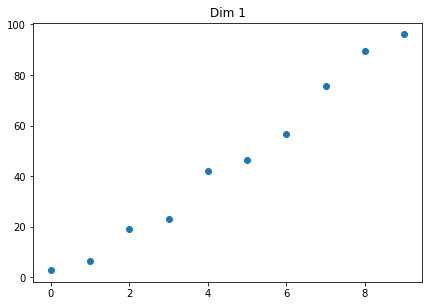

In [4]:
# Plot the observations
lm.plot_obs()

### `Models.ExponentialModel`
Below I implement the exponential model `em` with mathematical formulation
$$ f(X)=2e^{3X/10}+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,1) $$
Again, I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [5]:
# Specify the model
np.random.seed(16111998) # Fix random seed
em=ExponentialModel(
    params=[2,.3],
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=1,
)

# Observe the model (will be the same each time this object is observed)
em.observe()

[array([3.3560321]),
 array([2.54325222]),
 array([3.52141497]),
 array([3.01241223]),
 array([5.50316435]),
 array([5.61277964]),
 array([7.23215671]),
 array([11.03425435]),
 array([14.5800335]),
 array([17.80316803])]

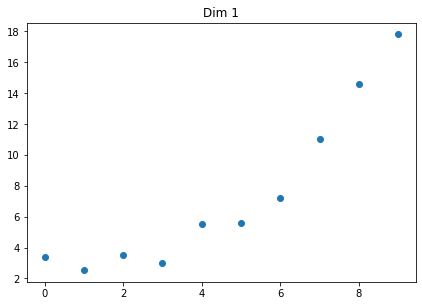

In [6]:
# Plot the observations
em.plot_obs()

## Kernels $K_\epsilon$
Kernels are functions which are used compare data by making it linearly seperable. Kernels are used in ABC to determine how similar simulated data is to observed data.

Most kernels have "bandwidth" parameter $\epsilon$ which specifies how similar data needs to be. A greater bandwidth means data doesn't need to be as similar, this leads to more observations being accepted and quicker computation, but decreased accuracy.

Here are some popular kernels for ABC
 * Uniform Kernel $K_\epsilon(x)=\mathbb{1}\{|x|\leq\epsilon\}$.
 * Epanechnikov Kernel $K_\epsilon(x)=\frac3{4\epsilon}\left(1-\frac{x^2}{\varepsilon^2}\right)\mathbb{1}\{|x|\leq\epsilon\}$.
 * Gaussian Kernel $K_\epsilon(x)=\frac1{\sqrt{2\pi}}\exp\left\{-\frac12x^2\right\}$
 
In ABC $x=\|s-s_{obs}\|\in\mathbb{R}$ where $s$ is the summary statistic value of a sample, $s_{obs}$ is the summary statistic value of the originally observed data and $\|\cdot\|$ is some distance measure (Typically euclidean).
 
These kernels return a weighting which is often interpretted, in ABC, as the probability that we accept a given simulation. In practice we sample from $p\sim\mathcal{U}[0,1]$ and if $p>K_\epsilon(x)$ then we accept the simulation.

## Summary Statistics $s$
A Summary statistic is a projection of high-dimensional data to a lower dimensional space.

$$ s:\mathbb{R}^m\to\mathbb{R}^p\text{ with }p\ll m $$

In ABC several summary statistics are applied to observed and simulated data in order to reduce the total dimensionality of data and thus reduce the computational requirements of each algorithm. The use of summary statistics is often required just to make the algorithms computationally tractable.

Greater reduction in dimensionality leads to more data being lost meaning the posterior produced by ABC is less accurate and less stable. This means the trade-off is between computational efficiency and model accuracy.

In most settings observed and simulated data consist of multiple observations each with multiple dimension meaning that summary statistics in ABC typically have the following signature
$$ s:\mathbb{R}^{n\times m}\to\mathbb{R}^p\text{ with }p\ll n\times m $$
where $n$ is the number of observations, $m$ is the dimension of each observation and $p$ is the dimension of the summary.

Moreover, as ABC uses several summary statistics and each can map to a different dimension we what $\sum p_i\ll n\times m$ where $\{p_1,\dots,p_k\}$ are the dimensions of the summaries produced by $k$ different summary statistics.

**Note**
When using multiple summary statistics more questions arise about which (if any) are more important. 

### Sufficiency
A set of summary statistics $S=\{s_1,\dots,s_k\}$ are said to be "Sufficient" if they carry enough data in order to fully determine the parameters of a model.
$$ \mathbb{P}(X|S(X),\theta)=\mathbb{P}(X|S(X))\text{ where }X\sim f_\theta(\cdot) $$

The *Pitman–Koopman–Darmois Theorem* states that sufficient sets of summary statistics only exist for distributions from the exponential family. As most real world distributions do not come from the exponential family this means we need to consider other qualities.

"Approximate Sufficiency" is a metric for finding sets of summary statistics whcih statisfy some optimality condition to do with sufficiency, and can be applied to any distribution.

## ABC Algorithms

In [7]:
import ABC

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Components of ABC
To perform ABC we typically need/define the following features
 * A set of $n$ observations $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ from our generative model with $y_{obs,i}\in\mathbb{R}^m$ for large $m$.
 * A theorised model $f_\theta(\cdot)$ for the generative model, which can be simualted from. (See [Modelling](#Modelling))
 * A prior $\pi_0(\cdot)$ for each parameter of the theorised model.
 * A set of summary statistics $s:\mathbb{R}^m\to\mathbb{R}^k$ mapping each observation $y_i$ to a lower dimension. (See [Summary Statistics](#Summary-Statistics-$s$))
 * A kernel $K_\epsilon(\cdot)$ with bandwith $\epsilon$. (See [Kernels](#Kernels))
 * A distance measure $\|\cdot\|$.

### ABC-Rejection Sampling
The rejection sampling algorithm is the simplist implementation of ABC.

The general premise is to keep randomly initialising and simulating our theorised model until enough "good" simulations have occured. A simulation is deemed "good" if it is sufficiently close to observed data from the true model.

**Algorithm**

Consider the setup described [above](#Components-of-ABC). Here is an algorithm for ABC-Rejection Sampling
<ol>
  <li>
      Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$.
      $$ s_{obs}=s(Y_{obs}) $$
  </li>
  <li>
      Repeat the followingUntil stopping condition is reached
  </li>
    <ol>
      <li>
          Sample a set of parameters $\tilde\theta_t$ from the priors $\pi_0(\theta)$.
          $$ \tilde\theta_t\sim\pi_0(\theta) $$
      </li>
      <li>
          Initialise the theorised model $f_{\tilde\theta_t}$ with the sampled parameters $\tilde\theta_t$ and simulate data $Y_t$.
        $$ Y_t\sim f_{\tilde\theta_t}(Y) $$
      </li>
      <li>
          Calculate the summary statistic values $s_t$ for the simulate data $Y_t$.
        $$ s_t=s(Y_t) $$
      </li>
      <li>
          Reject this simulation with probability $K_\epsilon(\|s_t-s_{obs}\|)$.
          <br>If the simulation is accepted then record the parameter values $\tilde\theta_t$ and summary statistic $s_t$.
      </li>
    </ol>
  <li>
    Return the accepted parameter values $\{\tilde\theta_1,\dots,\tilde\theta_N\}$.
  </li>
</ol>

Different variations on this algorithm have different stopping conditions:
 * *Fixed Number* ("Stop once $N$ simulations have been accepted"). Good as we can define how good a simulation needs to be accepted. Bad as an unknown number of simulations will be performed.
 * *Best Samples* ("Perform $M$ simulations and keep the best $N$"). Good as the algorithm will perform a known number of simulations. Bad as we cannot control how good the accepted simulations will be.

<a id="rejection_implementation"></a>
### Implementation
Here I shall demonstrate my implementation of the ABC-Rejection Sampling algorithm.

But first some details about my implementation:
 * In the *Fixed Number* variation, when using multiple summary statistics the distance function $\|\cdot\|$ is applied to each (simulated,observed) summary statistic pair, the $L_1$-Norm of these distances is then passed through the kernel to determine the probability that a simulation is accepted.
 * In the *Best Samples* variation, when using multiple summary statistics each simulation is given a weighting equal to the $L_1$-Norm of the distances between the observed and simulated summary statistic values. The simulations with the $N$ lowest weights are accepted.
 * The $L_2$-Norm is used as the distance function.
 
The distance functions and norms used here are worthy of further discussion. [TODO](#TODO)

<a id="rejection_linear_model"></a>
**Linear Model**

First I shall use the linear model defined [above](#Models.LinearModel). The true model here is $f(X)=1+10X+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$ (I am not going to estimate the variance of the additive noise).

Below I run the algorithm twice:
 * First time stops once 100 simulations have been accepted. Acceptance is determined by using a uniform kernel with bandwith $\epsilon=.7$.
 * Second time runs 1,000 simulations and uses the best 100.

In both cases the returned `fitted_model` uses the mean of the accepted values for each parameter. All simulations are given even weighting in this mean, but this could be extended to give greater weight to simulations which produce summary statistics which are close to $s_{obs}$.

**Priors**

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,6]$ and $\pi_0(\theta_1)\sim\mathcal{U}[8,14]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [8]:
# Define Priors
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

**Summary Statistics**

I have chosen three summary statistics
 * $s_0$ - Value of the first observation.
 * $s_1$ - Value of the last (tenth) observation.
 * $s_2$ - Mean change in value between consecutive observations.

In [9]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_grad]

(1,195) 100/100



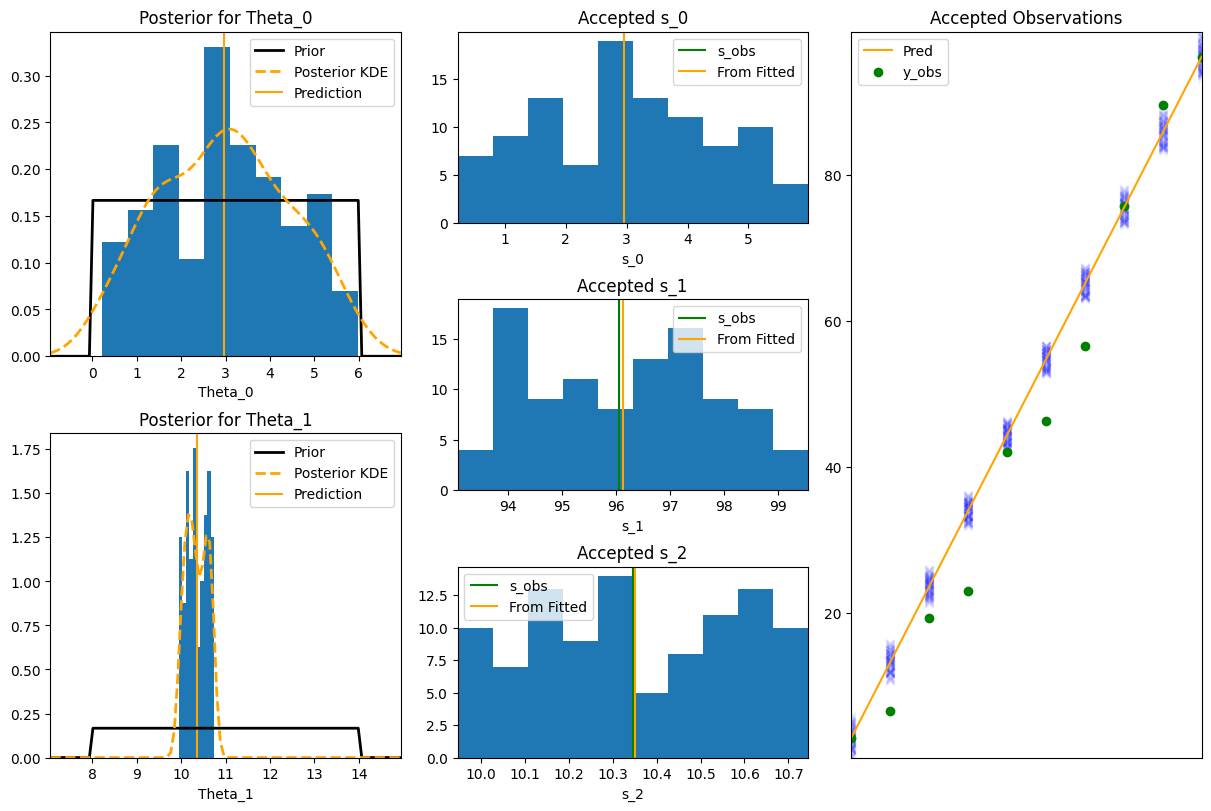

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.964+10.351*x0

Wall time: 12.5 s


In [10]:
%%time
# First Run - FIXED NUMBER - Until 100 acceptances
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"fixed_number","sample_size":100,"scaling_factor":4,"kernel_func":ABC.uniform_kernel}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

1,195 simulations were required for 100 to be accepted.

The returned fitted model was $\hat{f}(X)=2.964+10.351X$ which shows a good fit for the second coefficient, but not for the first. This is due to noise in the true model meaning that the first data point has value $\sim2.95$. Looking at the plot of the fitted model and accepted simulations (RHS), we can see that despite noise meaning many data points do not lie near their true value, the fitted model is very good.

The histograms for the accepted values of each summary statistic (middle col) show that the values which were accepted were very close to the true values for all summary statistics. This is to be expected due to this variation of the algorithm only accepting observations which are close (although my implementation only required 2/3 of the simulated summary statistic values  to be close to their observed counterparts).

The distributions for each parameter (left col) shows that the posteriors have a significantly different shape to the priors, indicating that significant learning has occurred. Moreover, a significant amount of weight in the posteriors is placed near the true parameter values.

(999/1,000)



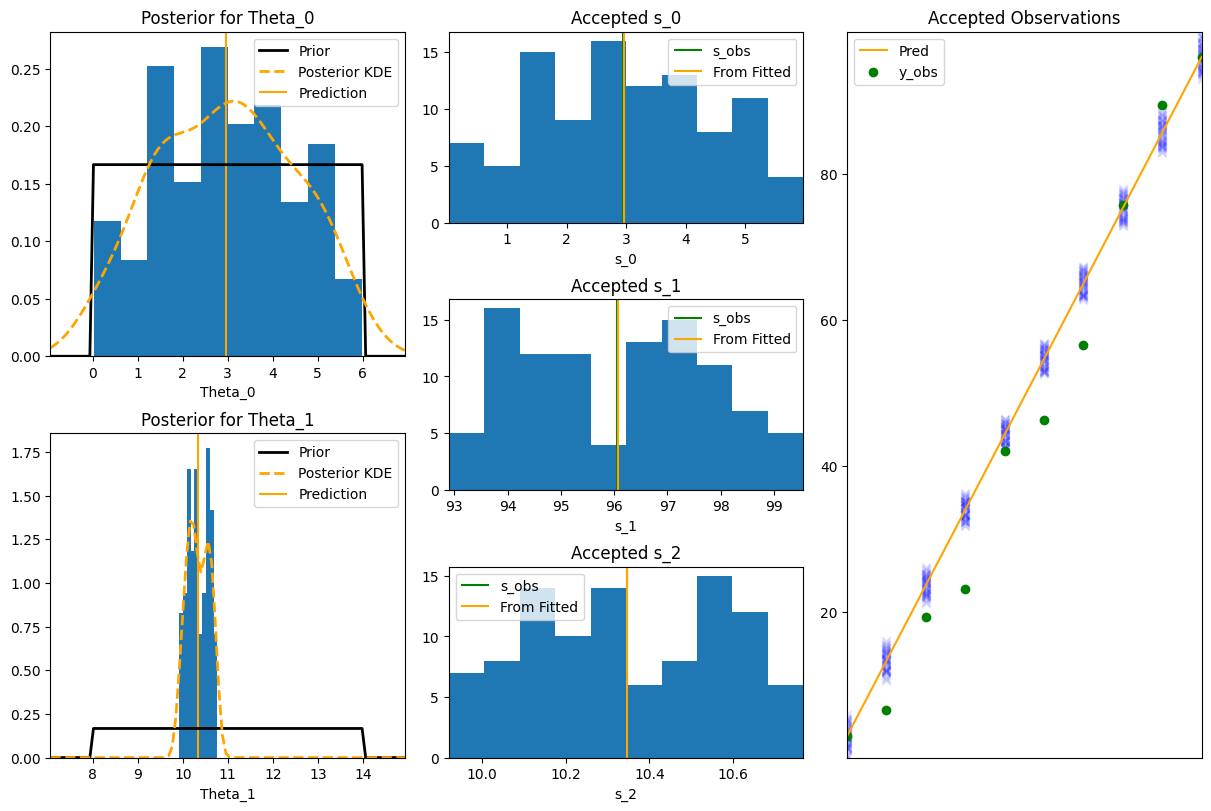

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.963+10.345*x0

Wall time: 10.9 s


In [11]:
%%time
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model was $\hat{f}(X)=2.963+10.345X$. This is very similar to the model returned by the *Fixed Number* variation above.

The analysis of the results here is very similar to that above, likely due to them both running a similiar number of iterations (with the same seed). The only notable difference is that the posterior for the first parameter $\theta_0$ in this variation is not that different from its prior, and the same can be seen in the accepted values of $s_0$. This is likely due to $\theta_0$ being less important to the overall fit of the theorised model than $\theta_1$ (Which is explainable and to be expected). The fact that the fitted model in both variations is almost identical emphasises this.

The fitted value $\hat\theta_0$ is likely only close to the observed value of the first data point as that value is close to the mean of the prior defined for $\theta_0$.

<a id="rejection_exponential_model"></a>
**Exponential Model**

Now I shall use the exponential model defined [above](#Models.ExponentialModel). The true model here is $f(X)=2\exp(3X/10)+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,1)$ and my theorised model is $f_\theta(X)=\theta_0\exp(\theta_1X)$. (I am not going to estimate the variance of the additive noise).

I only run the *Best Samples* variation of the algorithm, performing 1,000 simulations and accepting the best 100. I do not run both variations as I just wish to demonstrate that ABC-Rejection Sampling works on the slightly more complicated exponential model.

The returned `fitted_model` uses the mean of the accepted values for each parameter.

**Priors**

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,3]$ and $\pi_0(\theta_1)\sim\mathcal{U}[0,1]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [12]:
# Define Priors
em_priors=[stats.uniform(0,3),stats.uniform(0,1)]

**Summary Statistics**

I have chosen three summary statistics
 * $s_0$ - Value of the first observation.
 * $s_1$ - Value of the last (tenth) observation.
 * $s_2$ - Mean $\log$-change in value between consecutive observations.

In [13]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_log_grad = (lambda ys:[np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_log_grad]

(999/1,000)



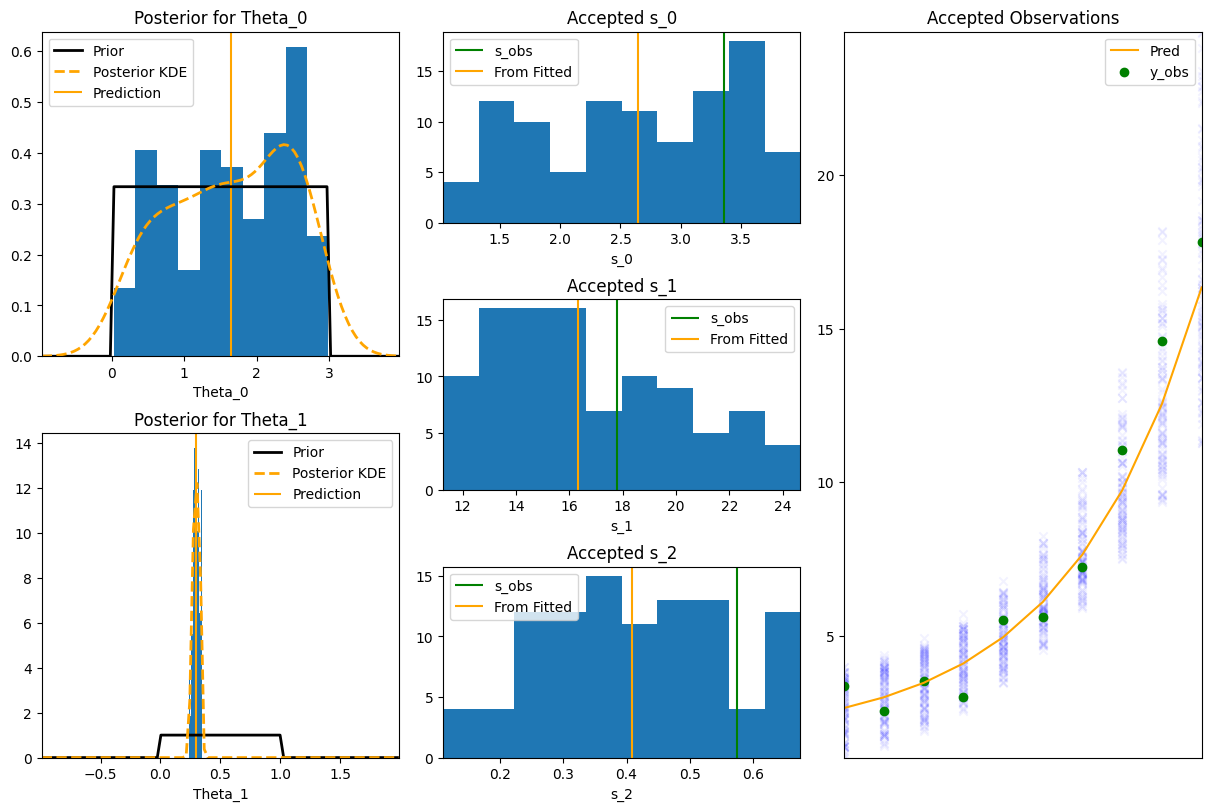

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 1.645*e^(0.299*x0)

Wall time: 10.3 s


In [14]:
%%time
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model is $\hat{f}(X)=1.645\exp(0.299X)$. This again shows a very good fit for $\theta_1$ but not for $\theta_0$. The posterior for $\theta_0$ is practically unchanged from its prior. Moreover, the fitted value $\hat\theta_0$ likely is just the mean of the prior assigned to $\theta_0$ (Indicating no learning has occured for $\theta_0$). While, the posterior for $\theta_1$ places almost all its weight on the true value.

This shows us that $\theta_1$ is a significantly more important parameter when fitting an exponential model than $\theta_0$. This can be seen by noting (in the right-hand plot) how well the fitted model fits the observed data.

### ABC-MCMC
The Markov Chain Monte Carlo (MCMC) version of ABC aims to search the parameter space in a much more informed way than ABC-Rejection Sampling.

The general premise of ABC-MCMC is to initally random search the parameter space until a good set of parameters are found; Then over a fixed number of steps: perturb this set of parameters, if the perturbed parameters are accepted by the kernel then accept them and use them going forwards (otherwise revert).

Further to [Components of ABC](#Components-of-ABC), ABC-MCMC requires a perturbance kernel $K^*(\cdot)$ which slightly changes a set of parameters, creating a random walk in the parameter space. A simple perturbance kernel is to add some gaussian noise.

**Algorithm**

Consider the setup described [above](#Components-of-ABC) and a perturbance kernel $K^*(\cdot)$. Here is an algorithm for ABC-MCMC with a chain of length $N$.
<ol>
  <li>Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$
    $$ s_{obs}=s(Y_{obs}) $$</li>
  <li><i>Burn In</i></li>
  <ol>
    <li>Sample a set of parameters $\tilde\theta_0$ from the priors $\pi_0(\theta)$.
    $$ \tilde\theta_0\sim\pi_0(\theta) $$</li>
    <li>Initialise the theorised model $f_{\tilde\theta_0}$ with the sampled parameters $\tilde\theta_0$ and simulate data $Y_0$
$$ Y_0\sim f_{\tilde\theta_0}(Y) $$</li>
    <li>Calculate the summary statistic values $s_0$ for the simulated data $Y_0$.
$$ s_0=s(Y_0) $$</li>
    <li> Accept this simulation with probability $K_\epsilon(\|s_0-s_{obs}\|)$. If the simulation is accepted set $t=0$ and move to the <i>3. MCMC Step</i></li>
  </ol>
    <li><i>MCMC Step</i></li>
  <ol>
    <li>Perturb the previously accepted parameter values $\tilde\theta_t$ to get a new set of parameters $\theta^*$
    $$ \theta^*=K^*(\tilde\theta_t) $$</li>
    <li>Initialise the theorised model $f_{\theta^*}$ with the perturbed parameters $\theta^*$ and simulate data $Y_{t+1}$
    $$ Y_{t+1}\sim f_{\theta^*}(Y) $$</li>
    <li>Calculate the summary statistic values $s_{t+1}$ for the simulated data $Y_{t+1}$.
$$ s_{t+1}=s(Y_{t+1}) $$</li>
    <li>Accept this simulation with probability $K_\epsilon(\|s_{t+1}-s_{obs}\|)$. If the simulation is accepted set $\tilde\theta_{t+1}=\theta^*$, otherwise set $\tilde\theta_{t+1}=\tilde\theta_t$</li>
    <li>Increment $t$</li>
  </ol>
  <li>Return the accepted parameter values $\{\tilde\theta_1,\dots,\tilde\theta_N\}$.</li>
</ol>

**Extensions**
It is easy for ABC-MCMC to get stuck if it steps into a region of low posterior density. There are a few extensions to the algorithm above to counter this (some of which can be combined), inc.
 * Run multiple chains.
 * Every time a simulation is rejected, losen the acceptance criteria. (Reset them when a simulation is accepted).
 * If a simulation has not been accepted in $M$ iterations, repeat the burn-in process.

Running multiple chains is a good idea as the burn-in step can mean that only one part of the posterior is explored. This is especially bad if the posterior is multi-modal. However, this either means more simulations need to be done total or each chain performs fewer.

<a id="mcmc_implementation"></a>
### Implementation

Here I implement the ABC-MCMC algorithm and apply it to the same [model](#Models.LinearModel) & [exponential model](#Models.ExponentialModel) as I did for the [ABC-Rejection Sampling](#rejection_implementation). To allow for a fair comparison of the algorithms I am using the same *Summary Statistics* and *Priors* for each model.

In both cases, I run the algorithm for a chain of length $N=1,000$ so their results can be compared to those from ABC-Rejection Sampling. For further consistency between the two algorithms, I use the uniform kernel with bandwidth $\epsilon=4$ as the acceptance kernel.

**Perturbance Kernels**<a id="mcmc_perturbance"></a>

Choosing optimal pertubance kernels is non-trivial as we need to consider their computational requirements and how efficient they are at exploring. Moreover, a more efficient kernel means that we can that can perform more simulations for the same computational requirement. See [this paper](https://drive.google.com/file/d/1-aHMmEIwfag23I81aW-C87UyOBRiq7rK/view?usp=sharing) for an in-depth review. Most perturbance kernels are centred around the input.

I chose to use a kernel which applies additive gaussian noise to the input. This kernel is equivalent to sampling $\tilde\theta\sim\mathcal{N}(\theta,\sigma^2I)$. Greater variance means that more of the parameter space can be explored in fewer simulations, however it is more likely a simulation will be reject as it is more likely the perturbed parameters fall outside areas of high posterior density. I use the same variance ($\sigma^2=.5$) for each dimension, but this can easily be extended to have a different variance for each dimension.

More complex kernels may consider:
 * Correlations between parameters, moving correlated parameters in similar directions.
 * Utilise Fisher Information to determine which parameters should be explored the most.
 
Tunning a perturbance kernel should be done in tandem with tuning the acceptance kernel as both affect the proportion of new simulations which are accepted. When tuning you should define a target proportion of new simulations to be accepted (~10\%) and tune accordingly.

In [15]:
perturbance_kernels = [lambda x:x+stats.norm(0,.5).rvs(1)[0]]*2

<a id="mcmc_linear_model"></a>
**Linear Model**

The true model is $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$.

In [16]:
# Define summary statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_grad]

Found Start - (2) [1.2988881859008132, 10.64653534018502]
0.595 observations were new.


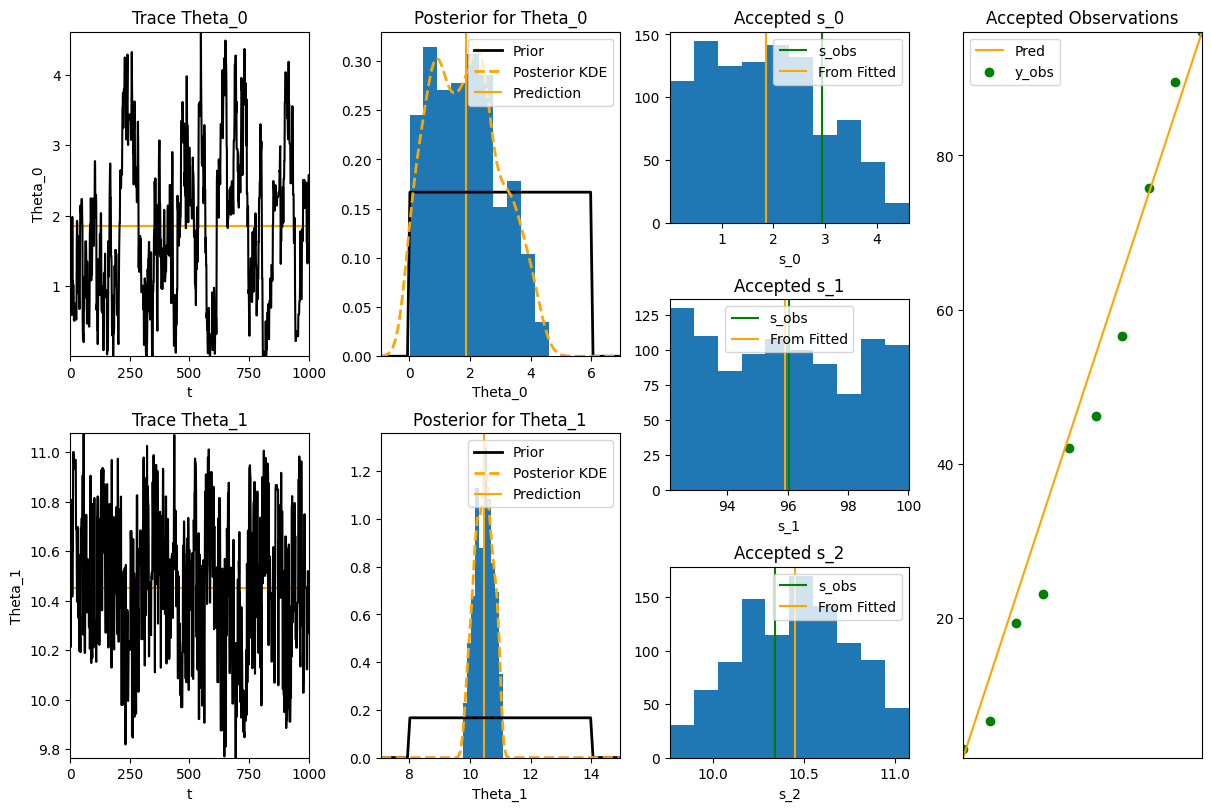

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 1.854+10.451*x0

Wall time: 12.2 s


In [17]:
%%time
# MCMC - Chain length=2000
np.random.seed(16111998) # Fix random seed
fitted_model=ABC.abc_mcmc(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.uniform_kernel,scaling_factor=4,
    summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

A very short burn-in was required (only 2 steps) and 59.5\% of simulations during the MCMC step were accepted. This is a much higher rate of acceptance than the ABC-Rejection Sampling variation which took 1,195 simulations to accept 100, suggesting ABC-MCMC is more efficient.

The returned fitted model is $\hat{f}(X)=1.854+10.341X$. This model has fitted $\theta_0$ better than ABC-Rejection sampling but fitted $\theta_1$ slightly worse.

A notable difference between these results and those of ABC-Rejection Sampling is the posterior (col. 3) for $\theta_0$. In rejection sampling the prior and posterior for this parameter were very similar, whereas this time they are clearly different shapes suggesting significantly more learning has occured. The trace of accepted values for $\theta_0$ (col. 1) show a good amount of exploration has occured.

<a id="mcmc_exponential_model"></a>
**Exponential Model**

The true model is $f(X)=2\exp\{3X/10\}+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,1)$. and my theorised model is $f_\theta(X)=\theta_0\exp\{\theta_1X\}$.

In [18]:
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_log_grad = (lambda ys:[np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_log_grad]

Found Start - (14) [1.6261446360346166, 0.29183876237837625]
0.065 observations were new.


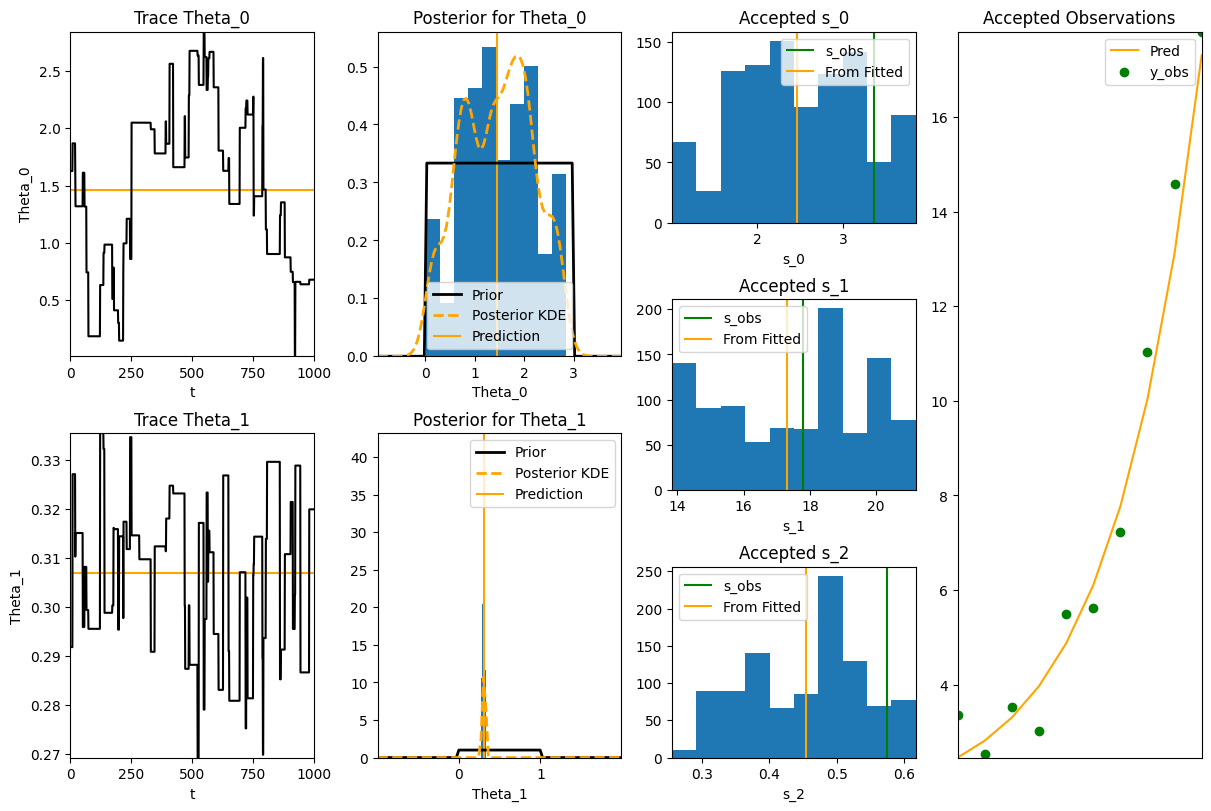

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 1.457*e^(0.307*x0)

Wall time: 13 s


In [19]:
%%time
# MCMC - Chain length=2000
np.random.seed(16111998) # Fix random seed
fitted_model=ABC.abc_mcmc(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
    chain_length=1000,perturbance_kernels=perturbance_kernels,acceptance_kernel=ABC.uniform_kernel,scaling_factor=4,
    summary_stats=summary_stats)
print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The burn-in for this model was longer than for the linear model (14 vs 2), but still not notably long. Only 6.5\% of simulations were accepted during the MCMC-step, this is significantly less than for the linear model and likely due to small changes in the parameters have much greater affects on the summary statistic values. This is reinforced by observing how narrow the range of accepted values for $\theta_1$ is in its MCMC trace (col. 1).

(Note that when I applied ABC-Rejection Sampling to this model I enforced an acceptance rate of 10\%).

The returned fitted model is $\hat{f}=1.456\exp(0.307X)$. This is a slightly worse for both parameters than when ABC-Rejection Sampling was applied, although still a very good fit.

The posteriors produced by this algorithm are very similar to those produced by ABC-Rejection Sampling. Again, it appears very little learning has occured for $\theta_0$ but significant learning has occured for $\theta_1$, emphasining the relative importance of each parameter to the models fit.


### ABC-SMC
The Sequential Monte Carlo (SMC) version of ABC aims to search the parameter space in a much more informed way than ABC-Rejection Sampling.

The general premise of ABC-SMC is to initially use a loose acceptance kernel to produce an initial sample of the parameter space, and then to refine this sample by resampling (with perturbance) and tightening the acceptance kernel.

ABC-SMC has the same features to be defined as ABC-MCMC, as well as a set of ever-tightening bandwidths $\{\epsilon_1,\dots,\epsilon_T\}$ for the acceptance kernel. A different bandwith should be defined for each resampling iteration.

ABC-SMC returns a sets of parameters along with a weight for each set, the weights correspond to the posterior weight for each parameter set.

**Algorithm**

Consider the setup described [above](#Components-of-ABC), a perturbance kernel $K^*(\cdot)$ and a set of bandwiths $\{\epsilon_0,\dots,\epsilon_T\}$. Here is an algorithm for ABC-SMC, with a sample size of $N$
<ol>
    <li>Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$
    $$ s_{obs}=s(Y_{obs}) $$</li>
    <li><i>Initial Sampling</i> - Set $t=0$ and $i=0$.</li>
    <ol>
        <li>Sample a set of parameters $\tilde\theta_{0,i}$ from the priors $\pi_0(\theta)$
        $$ \tilde\theta_{0,i}\sim\pi_0(\theta) $$</li>
        <li>Initialise the theorised model $f_{\tilde\theta_{0,i}}$ with the sampled parameters $\tilde\theta_{0,i}$ and simulate data $Y_{0,i}$
        $$ Y_{0,i}\sim f_{\tilde\theta_{0,i}}(Y) $$</li>
        <li>Calculate the summary static values $s_{0,i}$ for the simulated data $Y_{0,i}$.
        $$ s_{0,i}=s(Y_{0,i}) $$</li>
        <li>Accept this simulation with probability $K_{\epsilon_0}(\|s_{0,i}-s_{obs}\|)$. If the simulation is accepted: increment $i$, store the sampled parameters $\tilde\theta_{0,i}$ in set $\Theta_0$ and set weight $w_{0,i}=1/N$.</li>
        <li>If $i\equiv N$: set $i=0$, increment $t$ and move to <i>3. Resampling</i>.</li>
    </ol>
    <li><i>Resampling</i></li>
    <ol>
        <li>Sample a set of parameters $\tilde\theta_{t,i}$ from set $\Theta_{t-1}$ with each element in $\Theta_{t-1}$ weighted by $w_{t-1,j}$</li>
        $$ \mathbb{P}(\tilde\theta_{t,i}=\theta_j)=w_{t-1,j}\ \forall\ \theta_j\in\Theta_{t-1} $$</li>
        <li>Peturb the sampled parameters $\tilde\theta_{t,i}$ to produce new parameter set $\theta_{t,i}^*$
        $$ \theta_{t,i}^*=K^*(\tilde\theta_{t,i}) $$</li>
        <li>If $\theta_{t,i}^*$ is impossible under our prior $\pi_0(\theta)$ then return to step 3. A. (otherwise, continue).</li>
        <li>Initialise the theorised model $f_{\theta_{t,i}^*}$ with the perturbed parameters $\theta_{t,i}^*$ and simulate data $Y_{t,i}$
        $$Y_{t,i}\sim f_{\theta^*}(Y)$$</li>
        <li>Calculate the summary statistic values $s_{t,i}$ for the simulated data $Y_{t,i}$
        $$s_{t,i}=s(Y_{t,i})$$</li>
        <li>Accept the simulation with probability $K_{\epsilon_t}(\|s_{t,i}-s_{obs}\|)$. If the simulation is accepted, increment $i$, store the perturbed parameters $\theta_{t,i}^*$ in set $\Theta_t$ with weight $\tilde{w}_{t,i}$. If the simulation is rejected, return to step 3. A.
         $$ \tilde{w}_{t,i}=\dfrac{\pi_0(\theta_{t,i}^*)}{\sum_{j=1}^Nw_{t-1,j}\mathbb{P}(K^*(\tilde\theta_{t,i})=\theta_{t,i}^*)} $$</li>
        <li>If $|\Theta_t|<N$: return to step 3. A.</li>
        <li> Normalise weights $\tilde{w}_{t,i}$ st they form a probability distribution
        $$ w_{t,i}:=\dfrac{\tilde{w}_{t,i}}{\sum_{i=1}^Nw_{t,i}} $$
        </li>
        <li>If $t<T$: Increment $t$, otherwise move to step 4.</li>
    </ol>
    <li>Return the final sample along with their respective weights $\{(\theta_{T,1},w_{T,1}),\dots,(\theta_{T,N},w_{T,N})\}$</li>
</ol>

<a id="smc_implementation"></a>
### Implementation
Here I implement the ABC-SMC algorithm and apply it to the same [model](#Models.LinearModel) & [exponential model](#Models.ExponentialModel) as I did for the [ABC-Rejection Sampling](#rejection_implementation) * [ABC-MCMC](#ABC-MCMC). To allow for a fair comparison of the algorithms I am using the same *Summary Statistics* and *Priors* for each model.

In both cases, I run the algorithm with a sample size of $N=100$ and define a set of 10 different bandwiths which evenly partition the interval $[.5,3]$.

In my implementation of ABC-SMC I require that the set of bandwidths $\{\epsilon_0,\dots,\epsilon_T\}$ are defined explicitly and passed to the function as a parameter. However, this is not technically necessary. "Automatic" variations of ABC-SMC can allow for the bandwidths to be choosen after each iteration, with the value being chosen such that the next step has a desired expected acceptance rate. These variations require the definition of stopping conditions for when it is believed the posterior has converged sufficiently.

**Warning** I have not set up the implementations below st they make approximately the same number of simulations as the implementations above, meaning it is unfair to compare the outcomes of these different implementations. I have done this as otherwise the uniqueness of ABC-SMC would not be apparent. As a result, the implementations below take a lot longer to run than the implementations of ABC-MCMC and ABC-Rejection Sampling.

**Perturbance Kernels**

The comments for perturbance kernels for ABC-SMC are very similar to [those for ABC-MCMC](#mcmc_perturbance), except:
 * You need to be able the probability that the kernel produces a certain value given the input as this is needed to weight each sample.
 * Tuning of the perturbance kernels should be done in tandem with tuning the set of bandwidths.

In [20]:
perturbance_variance=.1

perturbance_kernels = [lambda x:x+stats.norm(0,perturbance_variance).rvs(1)[0]]*2
perturbance_kernel_probability = [lambda x,y:stats.norm(0,perturbance_variance).pdf(x-y)]

**Bandwidths**

There are several considerations when choosing a set of bandwidths for ABC-SMC. Not only the values, but also how many bandwidths to use. More bandwidths require more computational power, but will lead to a smoother convergence. Looser bandwidths mean more simulations will be accepted, reducing computational load, but the resulting estimate of the posterior will be more approximate. Greater decreases between consequitive bandwidths will likely require more computational power as the refinements to the posterior required are greater (TODO - totally reword this).

In [21]:
scaling_factors=list(np.linspace(3,.5,10))

<a id="smc_linear_model"></a>
**Linear Model**

The true model is $f(X)=1+10X+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$.

In [22]:
# Define summary statistics
np.random.seed(16111998) # Fix random seed
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_grad]

(823) - 100/100
(9/10 - 527) - 99/100 (0.500)
Total Simulations - 3,064
theta_hat - [2.9067570343539813, 10.350396001634705]


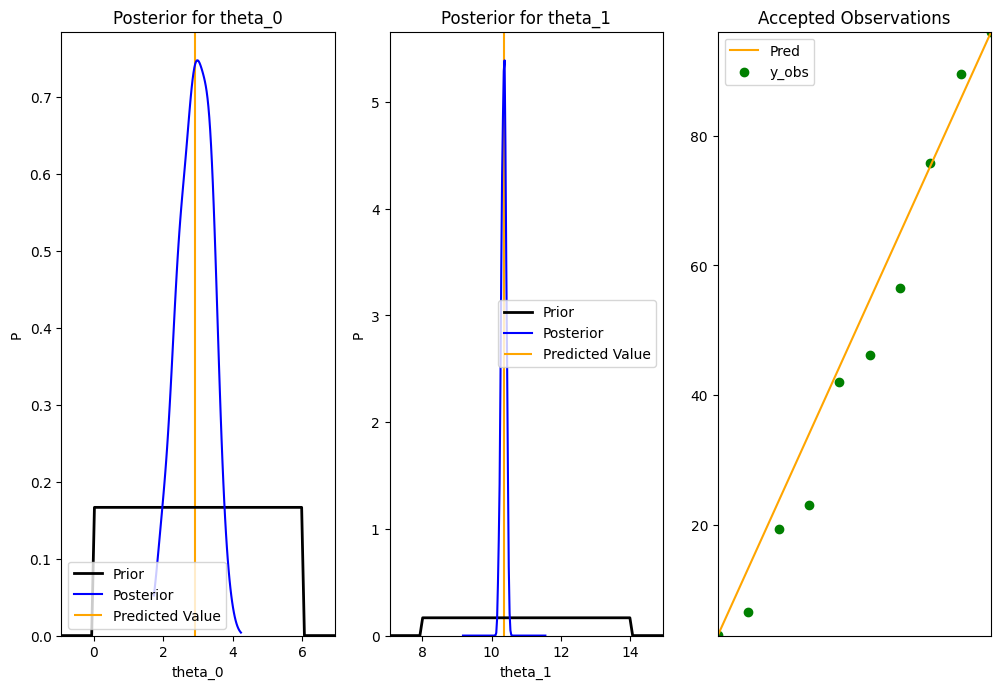

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.907+10.350*x0

Wall time: 1min 58s


In [23]:
%%time
# SMC - Sample Size=100
fitted_model=ABC.abc_smc(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,
    num_steps=10,sample_size=100,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,summary_stats=summary_stats)

print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

823 simulations were required to produce the initial sample $\Theta_0$ and a total of 3,064 simulations were required to complete the algorithm.

The fitted model is $\hat{f}(X)=2.907+10.350X$. This is a good fit, especially when considering the noise in the model and how it affects $\hat\theta_0$.

Comparing the priors and posteriors (cols 1,2) shows that significant learning has occurred, more than the other implementations. Notably, this is the only implementation which has indicated significantly learning for $\theta_0$, the reason for this is worth investigating (Likely due to confirmation bias from resampling, but potentially due to significantly increase in number of simulations performed).

**Note** I have produced fewer plots here than for ABC-Rejection Sampling and ABC-MCMC as it is harder to succicently visualise the data generated at each step whilst being able to distinguish between each step (and the amount of data produced). I do have some ideas, promise.

<a id="smc_exponential_model"></a>
**Exponential Model**

The true model is $f(X)=2\exp(3X/10)+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,1)$ and my theorised model is $f_\theta(X)=\theta_0\exp(\theta_1X)$.

In [24]:
# Define summary statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_log_grad = (lambda ys:[np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_log_grad]

(2,050) - 100/100
(9/10 - 4,231) - 99/100 (0.500)
Total Simulations - 15,052
theta_hat - [2.3674615920054984, 0.30456409885215857]


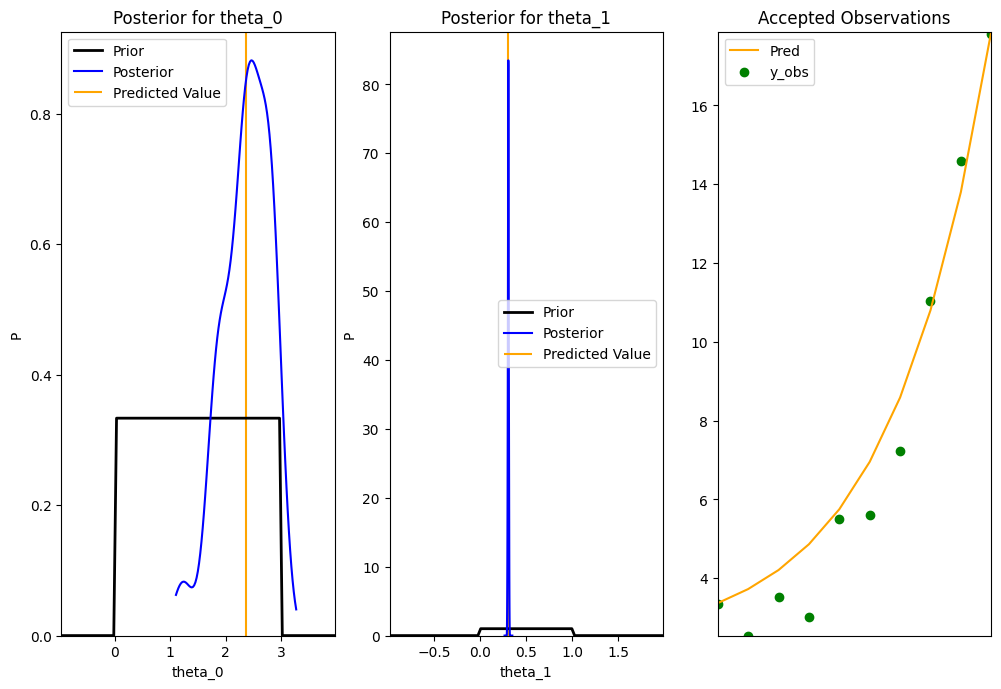

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 2.367*e^(0.305*x0)

Wall time: 4min 41s


In [25]:
%%time
# SMC - Sample Size=100
np.random.seed(16111998) # Fix random seed
fitted_model=ABC.abc_smc(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,
    num_steps=10,sample_size=100,scaling_factors=scaling_factors,perturbance_kernels=perturbance_kernels,perturbance_kernel_probability=perturbance_kernel_probability,acceptance_kernel=ABC.gaussian_kernel,summary_stats=summary_stats)

print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

2,050 simulations were required to produce the initial sample $\Theta_0$ and a total of 15,052 simulations were required to complete the algorithm. This is significantly more than were required for the linear model, showing how even a relatively small increase in model complexity affects ABC-SMC's performance.

The fitted model is $\hat{f}(X)=2.367\exp(0.305X)$. This is a very good fit, especially for $\hat\theta_1$ (the more important parameter).

Similar to the linear model, comparing priors and posteriors (cols. 1,2) show significant learning has occurred. Especially for $\theta_1$ where the posterior density is extremely concentrated. The reasons for the posterior for $\theta_0$ showing signifcant learning are likely the same as discussed for the linear model implementation.

## Discussion

### Limitations
Computationally Inefficient

### Decisions to make in each algorithm

# TODO
 * Priors
 * Sufficient statistics
     * Approximate Suffiency
 * ABC-Importance Sampling
 * Perturbance Kernels
 * General exploration & comparison